In [2]:
import splitfolders
from splitfolders.split import ratio

In [3]:
input_folder = "natural_images/input_dataset"
output = "natural_images/processed_dataset"
splitfolders.ratio(input_folder, output, seed=42, ratio=(.6, .2, .2))

KeyboardInterrupt: 

In [7]:
from json import load
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np


In [8]:
img_height, img_width = (244,244)
batch_size = 32

train_data_dir = r"natural_images\processed_dataset\train"
valid_data_dir = r"natural_images\processed_dataset\val"
test_data_dir = r"natural_images\processed_dataset\test"


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,

    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)

train_generator = train_datagen.flow_from_directory(

    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode= 'categorical',
    subset= 'training') # set as training data

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical',
    subset= 'validation') # set as validation data

Found 2484 images belonging to 8 classes.
Found 548 images belonging to 8 classes.


In [9]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation')


Found 552 images belonging to 8 classes.


In [10]:
x,y = test_generator.next()
x.shape

(1, 244, 244, 3)

In [11]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

history = model.fit(train_generator,epochs=3,batch_size=32)

Epoch 1/2
78/78 [==============================] - 224s 3s/step - loss: 0.1211 - accuracy: 0.9618
Epoch 2/2
78/78 [==============================] - 236s 3s/step - loss: 0.0158 - accuracy: 0.9964


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [12]:
model.save("natural_images\saved_model\ResNet50_Recon.h5")

C:\Users\Zeko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [13]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

552/552 - 61s - loss: 0.0525 - accuracy: 0.9873 - 61s/epoch - 111ms/step

Test accuracy: 0.9873188138008118


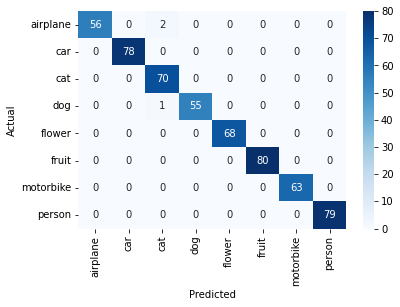

test accuracy: 99.45652173913044


In [ ]:
#%%
from sklearn.datasets import make_classification
import numpy as np
#%%
X, Y = make_classification(n_samples=2000, n_classes=2, n_features=10, random_state=0)
#%%
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
#%%
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2,
                                                    random_state=0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#%%
rf = RandomForestClassifier(max_features=5, n_estimators=500)
rf.fit(X_train, Y_train)
#%%
nb = GaussianNB()
nb.fit(X_train, Y_train)
#%%
r_probs = [0 for _ in range(len(Y_test))]
rf_probs = rf.predict_proba(X_test)
nb_probs = nb.predict_proba(X_test)
#%%
rf_probs = rf_probs[:, 1]
nb_probs = nb_probs[:, 1]
#%%
from sklearn.metrics import roc_curve, roc_auc_score
#%%
r_auc = roc_auc_score(Y_test, r_probs)
rf_auc = roc_auc_score(Y_test, rf_probs)
nb_auc = roc_auc_score(Y_test, nb_probs)
#%%
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('Naive Bayes: AUROC = %.3f' % (nb_auc))
#%%
r_fpr, r_tpr, _ = roc_curve(Y_test, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(Y_test, rf_probs)
nb_fpr, nb_tpr, _ = roc_curve(Y_test, nb_probs)
#%%
import matplotlib.pyplot as plt
#%%
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() #
# Show plot
plt.show()

#%%

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

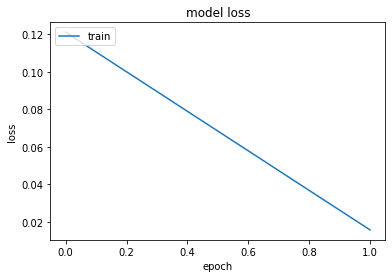

In [25]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc= 'upper left')
plt.show()